In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras 
from tensorflow.keras import layers
import os
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory

Applied code from https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
'''Convert all images to PNG -- run only one time'''

def save_images_as_png(folder_path, output_folder, image_size=(150, 150)):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                try:
                    with Image.open(file_path) as img:
                        # Create the output folder structure if it doesn't exist
                        relative_path = os.path.relpath(root, folder_path)
                        output_subfolder = os.path.join(output_folder, relative_path)
                        os.makedirs(output_subfolder, exist_ok=True)
                        # Convert and save the image as PNG
                        if img.mode == 'CMYK':
                            img = img.convert('RGB')
                        output_file_path = os.path.join(output_subfolder, filename.split('.')[0] + '.png')
                        img = img.resize(image_size)  # resizing image
                        #img = img.convert('L')  # Converting to grayscale
                        img.save(output_file_path, format='PNG')
                except Exception as e:
                    print(f"Error processing image '{file_path}': {e}")

folder_path = r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\logo findder"
output_folder=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\png logo findder"
save_images_as_png(folder_path, output_folder)

In [4]:
'''Tis will load the data with tf -- the png versions'''
folder_path=r"C:\Users\emili\OneDrive\Dokumente\03_Master_CBS\05_Summerterm24\01_ML and DL\Project\Augmented Images Pretrained"

train = image_dataset_from_directory(folder_path,
    seed=42,
    validation_split=0.2,
    subset='training',
    image_size=(224,224), #the model expects 224x224
)


Found 2667 files belonging to 14 classes.
Using 2134 files for training.


In [5]:
val =image_dataset_from_directory(folder_path, 
    seed=42,
    validation_split=0.2,
    subset='validation',
    image_size=(224,224),
)
# Printing class names
class_names = train.class_names
print("Class names:", class_names)

Found 2667 files belonging to 14 classes.
Using 533 files for validation.
Class names: ['AstonMartin', 'Audi', 'Bentley', 'Bugatti', 'Ferrari', 'FiskerAutomotive', 'Ford', 'Koenigsegg', 'Lamborghini', 'LotusCars', 'Maserati', 'Mercedes-AMG', 'Pagani', 'Porsche']


In [6]:
#augmentation
img_size=224

augment = tf.keras.Sequential([
    #layers.Resizing(img_size, img_size), #to make size every pic is 150x150 (necessary?)
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'), #flipping it
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness([-0.3,0.3]),
    tf.keras.layers.RandomRotation(0.1), #randomly rotate it
    #tf.keras.layers.Rescaling(1./255) #we aslo rescale it later so maybe not?
])

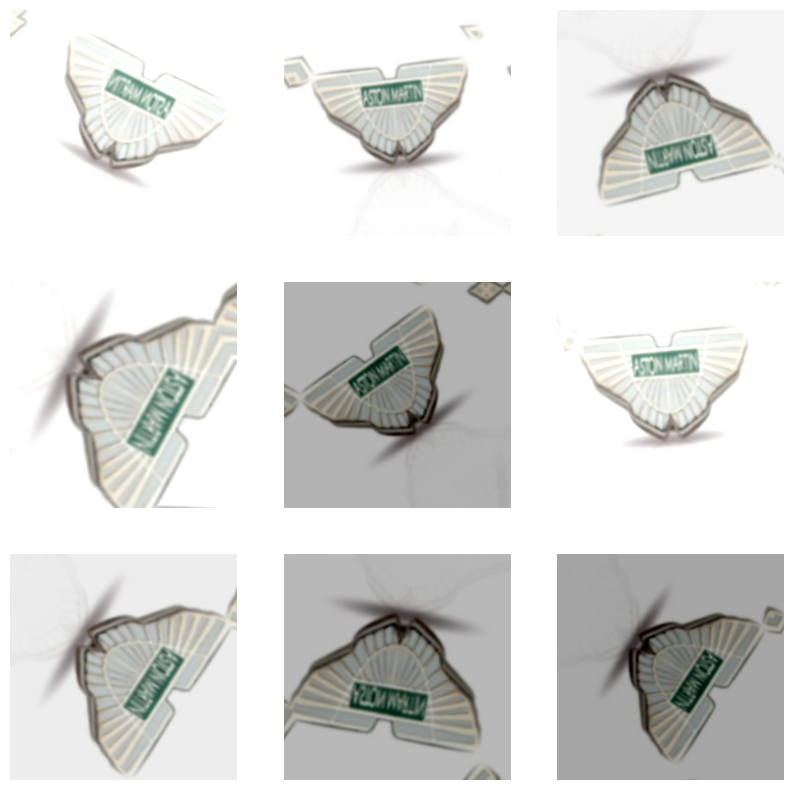

In [7]:
#plot the augmentations for one image
for image, _ in train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[3]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = augment(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
#Rescale pixel values
#model expects pixel values in [-1, 1] (right now they are [0, 255])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [9]:
#Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
#This feature extractor converts each image into a 7x7x1280 block of features
#example batch of images:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


Feature extraction
Next, the convolutional base created from the previous step will be frozen and used as a feature extractor. Additionally,  a classifier will be added on top of it and the top-level classifier trained.

Freeze the convolutional base
It is important to freeze the convolutional base before compiling and training the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [11]:
base_model.trainable = False

In [12]:
#look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
#Add lassification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
#Dense layer to convert features into a single prediction per image.
prediction_layer = tf.keras.layers.Dense(15, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 15)


In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = augment(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
#compile the model
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [18]:
#ovvio more than 2 epochs...
history = model.fit(train,
                    epochs=5,
                    validation_data=val)

Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 742ms/step - accuracy: 0.0464 - loss: 3.0482 - val_accuracy: 0.0488 - val_loss: 2.8147
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 725ms/step - accuracy: 0.0438 - loss: 2.9364 - val_accuracy: 0.0544 - val_loss: 2.7796
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 762ms/step - accuracy: 0.0562 - loss: 2.8762 - val_accuracy: 0.0694 - val_loss: 2.7496
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 718ms/step - accuracy: 0.0524 - loss: 2.8786 - val_accuracy: 0.0657 - val_loss: 2.7288
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 732ms/step - accuracy: 0.0419 - loss: 2.8167 - val_accuracy: 0.0525 - val_loss: 2.7145
